<a href="https://colab.research.google.com/github/princessivy/Analyzing_CSGO_SkinPrices/blob/main/CSGO_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import pandas as pd
import requests
import json

from google.colab import drive
from pathlib import Path

from PIL import Image
import requests
import cv2
import numpy as np

import time

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
#%reload_ext autoreload
#%autoreload 2

#Daten einlesen

In [ ]:
data = pd.read_csv(r'/content/drive/MyDrive/SA_BA/Data/allitems_w_colors.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
data.head()

,id,saleId,productId,assetId,itemId,appid,steamid,url,family,family_localized,...,collection,collection_localized,stickers,canHaveScreenshots,screenshots,souvenir,stattrak,tags,ownItem,colorfulness
0,0,6909421,5523872,46917102,9191,730,76561198837929747,bayonet-tiger-tooth-factory-new,Tiger Tooth,Tiger Tooth,...,NaN,NaN,[],True,"['playside', 'backside', 'image']",False,False,"[{'name': '★', 'name_localized': '★'}, {'name'...",False,59.790243
1,0,7653740,6120295,60753316,10318,730,76561198837492108,stattrak-bayonet-tiger-tooth-factory-new,Tiger Tooth,Tiger Tooth,...,NaN,NaN,[],True,"['playside', 'backside', 'image']",False,True,"[{'name': '★', 'name_localized': '★'}, {'name'...",False,57.181995
2,0,6835166,5463330,55716802,9191,730,76561198838929253,bayonet-tiger-tooth-factory-new,Tiger Tooth,Tiger Tooth,...,NaN,NaN,[],True,"['playside', 'backside', 'image']",False,False,"[{'name': '★', 'name_localized': '★'}, {'name'...",False,58.160273
3,0,5746569,4614623,43496004,9191,730,76561198837990201,bayonet-tiger-tooth-factory-new,Tiger Tooth,Tiger Tooth,...,NaN,NaN,[],True,"['playside', 'backside', 'image']",False,False,"[{'name': '★', 'name_localized': '★'}, {'name'...",False,58.489647
4,0,7664927,6129355,60829717,9191,730,76561198837298247,bayonet-tiger-tooth-factory-new,Tiger Tooth,Tiger Tooth,...,NaN,NaN,[],True,"['playside', 'backside', 'image']",False,False,"[{'name': '★', 'name_localized': '★'}, {'name'...",False,60.797777


#Beschreibung der Features
Der rohe Datensatz enthält die folgenden Features:

In [ ]:
data.columns

Index(['id', 'saleId', 'productId', 'assetId', 'itemId', 'appid', 'steamid',
       'url', 'family', 'family_localized', 'name', 'title', 'text',
       'marketName', 'marketHashName', 'color', 'bgColor', 'image', 'classid',
       'assetid', 'lock', 'version', 'versionType', 'stackAble',
       'suggestedPrice', 'salePrice', 'currency', 'saleStatus', 'saleType',
       'category', 'category_localized', 'subCategory',
       'subCategory_localized', 'pattern', 'finish', 'customName', 'wear',
       'link', 'type', 'exterior', 'quality', 'rarity', 'rarity_localized',
       'rarityColor', 'collection', 'collection_localized', 'stickers',
       'canHaveScreenshots', 'screenshots', 'souvenir', 'stattrak', 'tags',
       'ownItem', 'colorfulness'],
      dtype='object')

Folgende Tabelle erklärt die Bedeutung der einzelnen Features:

Feature | Bedeutung
--- | ---
id | wurde nicht herausgefunden, ist stetig '0'
saleId | eindeutige Verkaufs-ID
productId | eindeutige Produkt-ID
assetId | eindeutige Asset-ID
itemId| itemspezifische ID
appid | Zuordnung zur Applikation CS:GO, ist stetig '730'
steamid | KP??
url | spezifischer Bestandteil der gesamten URL für das Item
family | zugehörige Familie des Items (Unterunterkategorie)
family_localized | wie 'family' nur übersetzt in Sprache der Abfrage (hier: weiterhin englisch)
name | Anzeigename auf Skinport
title | angezeigte Unterkategorie zu jedem Item
text | kurze Beschreibung zum Item
marketName | Zusammensetzung aus 'title' und 'name'
marketHashName | wurde nicht herausgefunden, ähnlich zu 'marketName'
color | 4 Farben?! :D
bgColor | Wert nicht gepflegt, durchgehend 'NaN'
image | mit Ergänzung "https://steamcommunity-a.akamaihd.net/economy/image/" vor dem Wert, gelangt man an ein standardisiertes Cover-Bild des Items
classid | wurde nicht herausgefunden
assetid | weitere eindeutige Asset-ID
lock | Zeigt, ab wann Item zum Spieleinsatz freigegeben ist ('NaN' bedeutet, dass ein direkter Einsatz möglich ist)
version | verschiedene Doppler-Phasen von CS:GO
versionType | Zuordnung der 'version's in übergeordnete Kategorie
stackAble | wurde nicht herausgefunden, ist stetig 'False'
suggestedPrice | Wertvorschlag des Preises von Skinport
salePrice | Kaufpreis des Items
currency | Währung, ist stetig 'EUR'
saleStatus | gibt an, ob Item verkaufbar ist; ist stetig 'listed' und somit verkaufbar
saleType | gibt an, wer einen Kauf machen kann; ist stetig 'public' und somit für alle zugänglich
category | Überkategorie
category_localized | wie 'category' nur übersetzt in Sprache der Abfrage (hier: weiterhin englisch)
subCategory | Unterkategorie
subCategory_localized | wie 'subCategory' nur übersetzt in Sprache der Abfrage (hier: weiterhin englisch)
pattern | Musternummer des Items (zwischen 1 und 1000)
finish | Finish des Items
customName | Name des Items, von einem Besitzer hinzugefügt
wear | Abnutzung (zwischen 0 und 1)
link | wurde nicht herausgefunden
type | Typ des Items
exterior | Kategorie der Abnutzung, je nach 'wear'
quality | Kategorie der Qualität
rarity | Kategorie der Rarität
rarity_localized | wie 'rarity' nur übersetzt in Sprache der Abfrage (hier: weiterhin englisch)
rarityColor | Farbkategorie der Rarität
collection | Kollektion 
collection_localized | wie 'collection' nur übersetzt in Sprache der Abfrage (hier: weiterhin englisch)
stickers | Array mit Stickern, welche sich auf dem Item befinden
canHaveScreenshots | gibt an, ob Screenshots zum Item existieren; ist stetig 'True'
screenshots | gibt an, welche Screenshots zum Item existieren
souvenir | gibt an, ob das Item ein Souvenir ist oder nicht
stattrak | gibt an, ob das Item Stattrak-Eigenschaft hat oder nicht
tags | angegebene Tags auf Skinport
ownItem | gibt an, ob das Item unter Besitz steht; ist stetig 'False'
colorfulness | gibt die Farbintensität eines Skins an; umso höher, desto farbiger (Feature wurde zuvor berechnet)

Nun werden einige Features entfernt, die unbrauchbar sind. Nähere Erläuterung in Kapitel X der Seminararbeit.
(wenn immer nur gleicher Wert, können die auch weg, weil Varianz gleich;; wenn alle unterschiedlich sind, bringt das auch nix)

In [ ]:
data = data.drop(['id', 'saleId', 'productId', 'itemId', 'appid', 'steamid', 'url', 'family_localized', 'name', 'title', 'text', 'marketName', 'marketHashName', 'bgColor',
                  'image', 'classid', 'assetid', 'stackAble', 'currency', 'saleStatus', 'saleType', 'category_localized', 'subCategory_localized',
                  'customName', 'link', 'rarity_localized', 'collection_localized', 'canHaveScreenshots', 'screenshots', 'tags', 'ownItem'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
data.columns

Index(['assetId', 'family', 'color', 'lock', 'version', 'versionType',
       'suggestedPrice', 'salePrice', 'category', 'subCategory', 'pattern',
       'finish', 'wear', 'type', 'exterior', 'quality', 'rarity',
       'rarityColor', 'collection', 'stickers', 'souvenir', 'stattrak',
       'colorfulness'],
      dtype='object')

In [ ]:
len(data.columns) #Anzahl aktueller Feature (erste Bereinigung)

23

#Explorative Datenanalyse
Erster Eindruck über die Daten:

In [ ]:
data.head()

,assetId,family,color,lock,version,versionType,suggestedPrice,salePrice,category,subCategory,...,type,exterior,quality,rarity,rarityColor,collection,stickers,souvenir,stattrak,colorfulness
0,46917102,Tiger Tooth,#8650AC,NaN,default,default,39721,39913,Knife,Bayonet,...,★ Covert Knife,Factory New,★,Covert,#eb4b4b,NaN,[],False,False,59.790243
1,60753316,Tiger Tooth,#8650AC,2022-04-02T07:00:00.000Z,default,default,44203,36244,Knife,Bayonet,...,★ StatTrak™ Covert Knife,Factory New,★ StatTrak™,Covert,#eb4b4b,NaN,[],False,True,57.181995
2,55716802,Tiger Tooth,#8650AC,NaN,default,default,39721,40000,Knife,Bayonet,...,★ Covert Knife,Factory New,★,Covert,#eb4b4b,NaN,[],False,False,58.160273
3,43496004,Tiger Tooth,#8650AC,NaN,default,default,39721,42073,Knife,Bayonet,...,★ Covert Knife,Factory New,★,Covert,#eb4b4b,NaN,[],False,False,58.489647
4,60829717,Tiger Tooth,#8650AC,2022-04-03T07:00:00.000Z,default,default,39721,35500,Knife,Bayonet,...,★ Covert Knife,Factory New,★,Covert,#eb4b4b,NaN,[],False,False,60.797777


Datentypen angucken. Wichtige Unterscheidung zwischen numerischen und kategorialen Features:

In [ ]:
data.dtypes

assetId             int64
family             object
color              object
lock               object
version            object
versionType        object
suggestedPrice      int64
salePrice           int64
category           object
subCategory        object
pattern           float64
finish            float64
wear              float64
type               object
exterior           object
quality            object
rarity             object
rarityColor        object
collection         object
stickers           object
souvenir             bool
stattrak             bool
colorfulness      float64
dtype: object

Numerisch:
- assetId
- suggestedPrice
- salePrice
- pattern
- finish
- wear
- colorfulness

Kategorisch:
- family
- color
- lock
- version
- versionType
- category
- subCategory
- type
- exterior
- quality
- rarity
- rarityColor
- collection
- stickers
- souvenir
- stattrak


##Handhabung Missing-Values

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133005 entries, 0 to 133004
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   assetId         133005 non-null  int64  
 1   family          133005 non-null  object 
 2   color           133005 non-null  object 
 3   lock            29404 non-null   object 
 4   version         133005 non-null  object 
 5   versionType     133005 non-null  object 
 6   suggestedPrice  133005 non-null  int64  
 7   salePrice       133005 non-null  int64  
 8   category        133005 non-null  object 
 9   subCategory     133005 non-null  object 
 10  pattern         132989 non-null  float64
 11  finish          132838 non-null  float64
 12  wear            133005 non-null  float64
 13  type            133005 non-null  object 
 14  exterior        133005 non-null  object 
 15  quality         133005 non-null  object 
 16  rarity          133005 non-null  object 
 17  rarityColo

In [ ]:
data.shape

(133005, 23)

In [ ]:
data = data.drop_duplicates()

In [ ]:
data.shape #es gibt keine Duplikate

(133005, 23)

In [ ]:
data.isnull().sum()

assetId                0
family                 0
color                  0
lock              103601
version                0
versionType            0
suggestedPrice         0
salePrice              0
category               0
subCategory            0
pattern               16
finish               167
wear                   0
type                   0
exterior               0
quality                0
rarity                 0
rarityColor            0
collection          4680
stickers               0
souvenir               0
stattrak               0
colorfulness           0
dtype: int64

In den Features *lock, pattern, finish* und *collection* finden sich Null-Werte. Diese werden nun behandelt. 

**lock** Bei *lock* geht es darum, ob die Items nach dem Kauf direkt zum Spiel einsetzbar sind: Ja oder Nein. Ein 'NaN' steht in diesem Fall für "ja"(1), eine Zeitangabe für "nein"(0). Entsprechend entsteht hieraus ein Boolean.  
(Dauer: 2 Minuten)

In [ ]:
for x in range(len(data)):
  try:
    if np.isnan(data.lock[x]):
      data.lock[x] = 0
  except:
    data.lock[x] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**pattern** Die fehlenden Werte lassen sich hier nicht einfach durch Binärisierung oder Imputation lösen. Solche Annahmen über das Pattern würden die Daten eher verfälschen. Da es sich bei den 16 fehlenden Werten um einen Anteil von 0,012% handelt, werden diese hiermit aus dem Datensatz entfernt.

In [ ]:
data.shape

(133005, 23)

In [ ]:
data = data[data['pattern'].notna()]

In [ ]:
data.shape

(132989, 23)

**finish** Selbes Vorgehen wie bei *pattern*. Der Anteil, gemessen an der neuen Datenbasis, liegt bei 0,126%.

In [ ]:
data = data[data['finish'].notna()]

In [ ]:
data.shape

(132822, 23)

In [ ]:
#Index wieder richten
data = data.reset_index()

**collection** Die Items, die keiner Kollektion zugeordnet sind, werden zur Kollektion "No Collection" umbenannt und bilden somit eine weitere Kategorie.

In [ ]:
 data['collection'] = data['collection'].fillna("No Collection")

##Datentypenanpassung
*suggestedPrice* und *salePrice* sollten float's sein. Die Trennung zwischen Euros und Cents fehlt. Diese Variablen werden durch 100 geteilt, um dies zu lösen

In [ ]:
data['salePrice'] = data['salePrice']/100
data['suggestedPrice'] = data['suggestedPrice']/100

*pattern* liegt zwischen 1 und 1000. Dabei handelt es sich nicht um einen float-Wert. Dieser Wert wird auf int gecastet.

In [ ]:
data = data.astype({"pattern": int})

*finish* ist ebenso ein float, welcher eigentlich einem int enstpricht. Deshalb Casting.

In [ ]:
data = data.astype({"finish": int})

Um das Feature *stickers* richtig zu verarbeiten, wird dieses zu einer boolschen Variable umgeschrieben. Sticker: Ja(1) oder Nein(0).  
(Dauer: 2 Minuten, 30 Sekunden)

In [ ]:
for x in range(len(data)):
  if data.stickers[x] == '[]':
    data.stickers[x] = 0
  else:
    data.stickers[x] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


*souvenir* steht aktuell auf "True" oder "False". Hier wird eine Umformung in 0 und 1 vorgenommen. Das selbe gilt für *stattrak*.

In [ ]:
#souvenir
data["souvenir"] = data["souvenir"].astype(int)

#stattrak
data["stattrak"] = data["stattrak"].astype(int)

##Aktuelle Übersicht der Daten (inkl. Zwischenspeicherpunkt + Erweiterung um ein Feature)

**Übersicht**

In [ ]:
data.describe()

,index,assetId,lock,suggestedPrice,salePrice,pattern,finish,wear,stickers,souvenir,stattrak,colorfulness
count,132822.000000,1.328220e+05,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000
mean,66580.896501,4.724622e+07,0.220423,29.443286,34.422234,500.392533,647.262283,0.255292,0.179104,0.063988,0.099991,14.713770
std,38352.754248,1.329716e+07,0.414533,202.335509,372.976511,288.729975,1106.288792,0.177134,0.383441,0.244732,0.299989,11.226566
min,0.000000,1.240700e+04,0.000000,0.030000,0.020000,0.000000,2.000000,0.000007,0.000000,0.000000,0.000000,0.997502
25%,33377.250000,3.878514e+07,0.000000,0.030000,0.030000,250.000000,136.000000,0.125445,0.000000,0.000000,0.000000,7.197160
50%,66583.500000,5.176906e+07,0.000000,0.100000,0.120000,500.000000,611.000000,0.223606,0.000000,0.000000,0.000000,11.842459
75%,99792.750000,5.838940e+07,0.000000,1.590000,3.000000,751.000000,841.000000,0.361484,0.000000,0.000000,0.000000,18.906793
max,133004.000000,6.096650e+07,1.000000,16609.350000,49999.990000,1000.000000,10088.000000,0.999827,1.000000,1.000000,1.000000,91.185190


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132822 entries, 0 to 132821
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   index              132822 non-null  int64  
 1   assetId            132822 non-null  int64  
 2   family             132822 non-null  object 
 3   color              132822 non-null  object 
 4   lock               132822 non-null  int64  
 5   version            132822 non-null  object 
 6   versionType        132822 non-null  object 
 7   suggestedPrice     132822 non-null  float64
 8   salePrice          132822 non-null  float64
 9   category           132822 non-null  object 
 10  subCategory        132822 non-null  object 
 11  pattern            132822 non-null  int64  
 12  finish             132822 non-null  int64  
 13  wear               132822 non-null  float64
 14  type               132822 non-null  object 
 15  exterior           132822 non-null  object 
 16  qu

In [ ]:
data.corr()

,index,assetId,lock,suggestedPrice,salePrice,pattern,finish,wear,stickers,souvenir,stattrak,colorfulness
index,1.000000,-0.140313,-0.126812,-0.108998,-0.062490,0.000838,0.166137,0.083231,-0.070631,0.105433,-0.083764,-0.287664
assetId,-0.140313,1.000000,0.403910,0.068147,0.030457,0.002101,0.148028,-0.134380,0.184417,0.049078,0.145613,0.247528
lock,-0.126812,0.403910,1.000000,0.074314,0.032009,-0.000332,0.122777,-0.105988,0.063915,-0.060809,0.117913,0.229310
suggestedPrice,-0.108998,0.068147,0.074314,1.000000,0.600735,-0.000626,0.139426,-0.093623,0.005709,-0.029624,0.030637,0.107737
salePrice,-0.062490,0.030457,0.032009,0.600735,1.000000,0.000718,0.075264,-0.059444,0.027233,-0.013751,0.027065,0.069501
pattern,0.000838,0.002101,-0.000332,-0.000626,0.000718,1.000000,-0.000575,-0.000641,0.001541,0.002937,-0.001540,-0.000117
finish,0.166137,0.148028,0.122777,0.139426,0.075264,-0.000575,1.000000,-0.007651,-0.004620,0.017879,0.009869,0.075218
wear,0.083231,-0.134380,-0.105988,-0.093623,-0.059444,-0.000641,-0.007651,1.000000,-0.144034,-0.079244,-0.020883,-0.251165
stickers,-0.070631,0.184417,0.063915,0.005709,0.027233,0.001541,-0.004620,-0.144034,1.000000,0.554782,0.082884,0.194614
souvenir,0.105433,0.049078,-0.060809,-0.029624,-0.013751,0.002937,0.017879,-0.079244,0.554782,1.000000,-0.087150,0.036116


In [ ]:
# Speicherpunkt 1: Zwischenspeichern der Daten, sodass Prozess nicht immer wieder durchlaufen werden muss
data.to_csv(r'allitems_cleaned_1.csv', index=False, header=True)

In [ ]:
# Ladepunkt 1: Laden der Daten, sodass hier eingestiegen werden kann
data = pd.read_csv(r'/content/drive/MyDrive/SA_BA/Data/allitems_cleaned_1.csv')

**Neues Feature "cats_colorfulness"**

Die Berechnung des Features "colorfulness" wurde nach Hasler und Süsstrunk’s wissenschaftlicher Arbeit namens "Measuring colorfulness in natural images" (2003) berechnet. Hieraus wird nun die Kategorisierung der Colorfulness gezogen und ein neues Feature entsteht:

In [ ]:
def color_cats(x):
  if x == 0:
    return "not colorful"
  elif x > 0 and x <= 15:
    return "slightly colorful"
  elif x > 15 and x <= 33:
    return "moderately colorful"
  elif x > 33 and x <= 45:
    return "averagely colorful"
  elif x > 45 and x <= 59:
    return "quite colorful"
  elif x > 59 and x <= 82:
    return "highly colorful"
  elif x > 82:
    return "extemely colorful"

In [ ]:
data["cats_colorfulness"] = data["colorfulness"].apply(color_cats)

##Balanced oder Imbalanced Data?

In [ ]:
data['category'].value_counts()

Rifle     43665
Pistol    37346
SMG       28128
Heavy     17465
Knife      4604
Gloves     1614
Name: category, dtype: int64

Maßtabberechnung: Die Kategorie mit der niedrigsten Anzahl (hier: Gloves) wird auf 1 gesetzt und das Verhältnis zu Rifle wird berechnet (43664/1614). Somit ergibt sich zwischen Gloves und Rifle ein Verhältnis von 1:27,05. Nach Haibo und Garcia (2009, S. 1264) wird erst ab 1:100 von einem ungleichgewichtigen Datensatz gesrpochen. Entsprechend wird dieses Thema in dieser Arbeit nicht weiter bearbeitet.

##Visualisierungen - Get to Know the Data

###Ausreißer

In [ ]:
plt.rcParams.update({'font.size': 20, 'figure.figsize': (12, 10)})

In [ ]:
#Kategorische: Bar Charts & Boxplots
#Numerische: Histogramme, Scatterplotts, Line Graph & Boxplots

Zuerst wird geguckt, ob es preisliche Ausreißer gibt:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


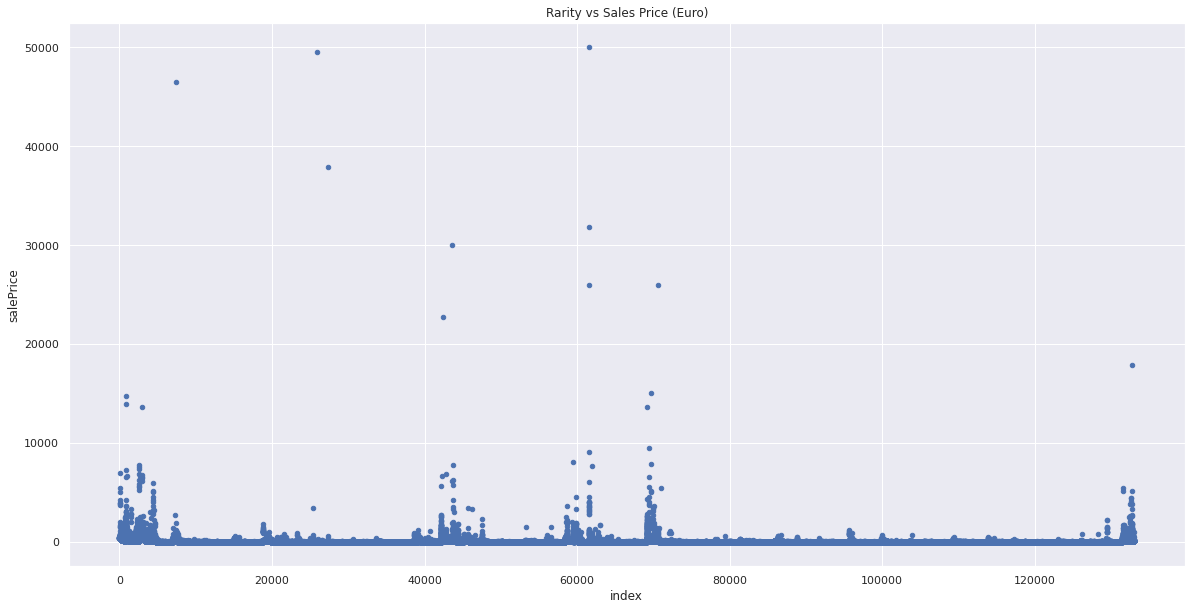

In [ ]:
data.plot(kind='scatter', x='index', y='salePrice', title='Rarity vs Sales Price (Euro)');

Hier sind nun bei über einem salePrice-Wert von über 10.000€ einige Ausreißer zu sehen. Diese werden nun genauer angesehen:

In [ ]:
data_ue10k = data[data['salePrice'] >= 10000]

In [ ]:
data_ue10k

,index,assetId,family,color,lock,version,versionType,suggestedPrice,salePrice,category,...,exterior,quality,rarity,rarityColor,collection,stickers,souvenir,stattrak,colorfulness,cats_colorfulness
800,822,41787087,Doppler,#8650AC,0,Sapphire,phase,13461.54,13906.90,Knife,...,Factory New,★,Covert,#eb4b4b,The Breakout Collection,0,0,0,26.052475,moderately colorful
846,868,57386498,Gamma Doppler,#8650AC,0,Emerald,phase,14697.21,14700.87,Knife,...,Factory New,★,Covert,#eb4b4b,The Breakout Collection,0,0,0,16.608317,moderately colorful
2932,2998,47663996,Doppler,#8650AC,1,Sapphire,phase,9940.10,13627.13,Knife,...,Factory New,★,Covert,#eb4b4b,No Collection,0,0,0,46.872878,quite colorful
7253,7421,42288854,Cobalt Disruption,#D2D2D2,0,default,default,61.49,46505.17,Pistol,...,Factory New,Normal,Classified,#d32ee6,The eSports 2013 Winter Collection,1,0,0,43.392093,averagely colorful
25724,25895,45506601,Valence,#D2D2D2,0,default,default,0.60,49560.28,Pistol,...,Factory New,Normal,Mil-Spec Grade,#4b69ff,The Chroma 2 Collection,1,0,0,48.083679,quite colorful
27121,27292,43907576,Sand Dune,#FFD700,0,default,default,0.39,37880.51,Pistol,...,Well-Worn,Souvenir,Consumer Grade,#b0c3d9,The Dust 2 Collection,1,1,0,28.512152,moderately colorful
42223,42395,36210877,Redline,#CF6A32,0,default,default,154.38,22711.88,Rifle,...,Minimal Wear,StatTrak™,Classified,#d32ee6,The Phoenix Collection,1,0,1,10.358685,slightly colorful
43479,43651,49905872,Case Hardened,#CF6A32,0,Tier 2,pattern,265.04,30000.00,Rifle,...,Minimal Wear,StatTrak™,Classified,#d32ee6,The Arms Deal Collection,1,0,1,20.445109,moderately colorful
61329,61501,33573999,Howl,#CF6A32,0,default,default,16609.35,26000.00,Rifle,...,Factory New,StatTrak™,Covert,#eb4b4b,No Collection,1,0,1,24.433518,moderately colorful
61332,61504,26587537,Howl,#CF6A32,0,default,default,16609.35,31795.72,Rifle,...,Factory New,StatTrak™,Covert,#eb4b4b,No Collection,1,0,1,25.731520,moderately colorful


Hierbei handelt es sich um genau 15 Beobachtungen, welche im salePrice einen Wert größer 10.000€ haben. Der salePrice ist der Preis, welcher vom Verkäufer festgelegt wird, wenn das zu verkaufende Item inseriert wird. Dies bedeutet, dass hier willkürlich gesetzte Preise eingetragen werden können. Die Variable suggestedPrice hingegen ist der geschätzte Preis von SkinPort für die Skins, welcher realistischer an der Preisschätzung der Skins liegt. Dies zeigt sich auch im kommenden Diagramm wieder (hier gibt es weniger Ausreißer). Zuerst jedoch die Varianz von suggestedPrice und salePrice, welche die Aussage nochmals unterstreicht:

In [ ]:
# Varianz von suggestedPrice
round(data.suggestedPrice.var(),2)

40939.66

In [ ]:
# Varianz von salePrice
round(data.salePrice.var(),2)

139111.48

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


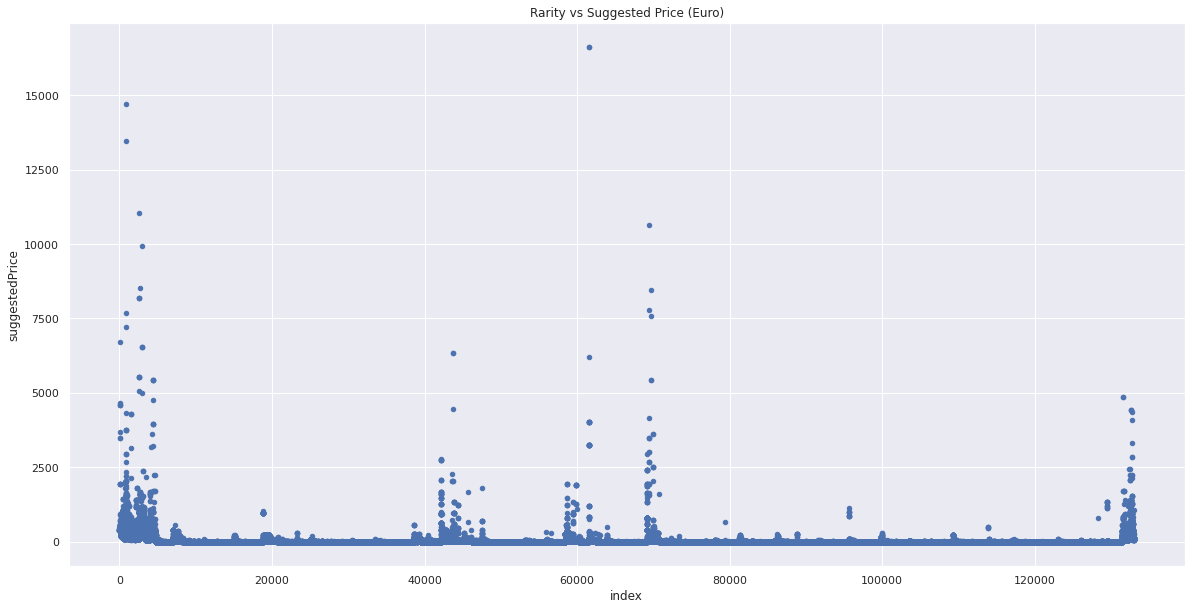

In [249]:
data.plot(kind='scatter', x='index', y='suggestedPrice', title='Rarity vs Suggested Price (Euro)');

Wie nun bei suggestedPrice zu sehen ist, gibt es weniger extreme Ausreißer nach oben. Hier die "Ausreißer" über 7.000€:

In [246]:
data.sort_values('suggestedPrice', ascending=False).head(5)

,index,assetId,family,color,lock,version,versionType,suggestedPrice,salePrice,category,...,exterior,quality,rarity,rarityColor,collection,stickers,souvenir,stattrak,colorfulness,cats_colorfulness
61329,61501,33573999,Howl,#CF6A32,0,default,default,16609.35,26000.00,Rifle,...,Factory New,StatTrak™,Covert,#eb4b4b,No Collection,1,0,1,24.433518,moderately colorful
61332,61504,26587537,Howl,#CF6A32,0,default,default,16609.35,31795.72,Rifle,...,Factory New,StatTrak™,Covert,#eb4b4b,No Collection,1,0,1,25.731520,moderately colorful
846,868,57386498,Gamma Doppler,#8650AC,0,Emerald,phase,14697.21,14700.87,Knife,...,Factory New,★,Covert,#eb4b4b,The Breakout Collection,0,0,0,16.608317,moderately colorful
800,822,41787087,Doppler,#8650AC,0,Sapphire,phase,13461.54,13906.90,Knife,...,Factory New,★,Covert,#eb4b4b,The Breakout Collection,0,0,0,26.052475,moderately colorful
2512,2570,25506060,Doppler,#8650AC,0,Sapphire,phase,11038.07,7777.77,Knife,...,Minimal Wear,★,Covert,#eb4b4b,No Collection,0,0,0,55.255036,quite colorful


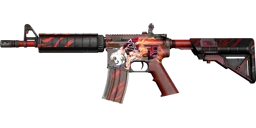

In [235]:
#teuerstes skin
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/33573999/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

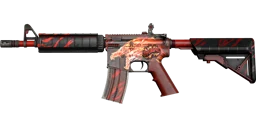

In [225]:
#zweitteuerstes skin
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/26587537/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

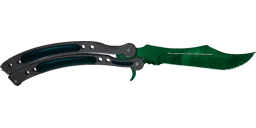

In [226]:
#drittteuerstes skin
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/57386498/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

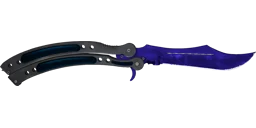

In [228]:
#viertteuerstes skin
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/41787087/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

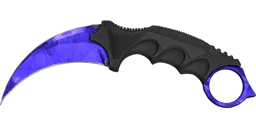

In [229]:
#fünftteuerstes skin 
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/25506060/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

In [241]:
#die 3 billigsten Skins
data.sort_values('suggestedPrice', ascending=False).tail(5)

,index,assetId,family,color,lock,version,versionType,suggestedPrice,salePrice,category,...,exterior,quality,rarity,rarityColor,collection,stickers,souvenir,stattrak,colorfulness,cats_colorfulness
80692,80865,50371950,Contractor,#D2D2D2,0,default,default,0.03,0.03,Rifle,...,Minimal Wear,Normal,Consumer Grade,#b0c3d9,The Safehouse Collection,0,0,0,9.989925,slightly colorful
80691,80864,33179215,Contractor,#D2D2D2,0,default,default,0.03,0.02,Rifle,...,Field-Tested,Normal,Consumer Grade,#b0c3d9,The Safehouse Collection,0,0,0,8.196319,slightly colorful
80690,80863,26513878,Contractor,#D2D2D2,0,default,default,0.03,1.36,Rifle,...,Battle-Scarred,Normal,Consumer Grade,#b0c3d9,The Safehouse Collection,0,0,0,5.330830,slightly colorful
80689,80862,54212789,Contractor,#D2D2D2,0,default,default,0.03,0.03,Rifle,...,Minimal Wear,Normal,Consumer Grade,#b0c3d9,The Safehouse Collection,0,0,0,9.986137,slightly colorful
32352,32524,14594134,Bone Mask,#D2D2D2,0,default,default,0.03,0.03,Pistol,...,Well-Worn,Normal,Consumer Grade,#b0c3d9,The Bank Collection,0,0,0,8.400256,slightly colorful


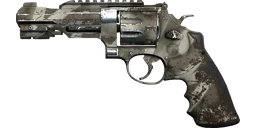

In [238]:
#billigstes skin
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/14594134/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

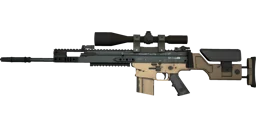

In [239]:
#zweitbilligstes skin 
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/54212789/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

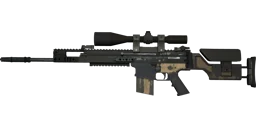

In [240]:
#drittbilligstes skin
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/26513878/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

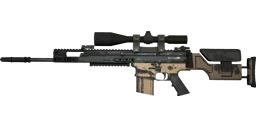

In [242]:
#viertbilligstes skin
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/33179215/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

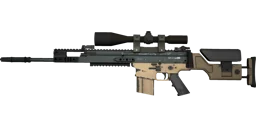

In [243]:
#fünftbilligstes skin
url = "https://cdn.skinport.com/cdn-cgi/image/width=256,height=128,fit=pad,format=webp,quality=85,background=transparent/images/screenshots/50371950/playside.png"
im = Image.open(requests.get(url, stream=True).raw)
im

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


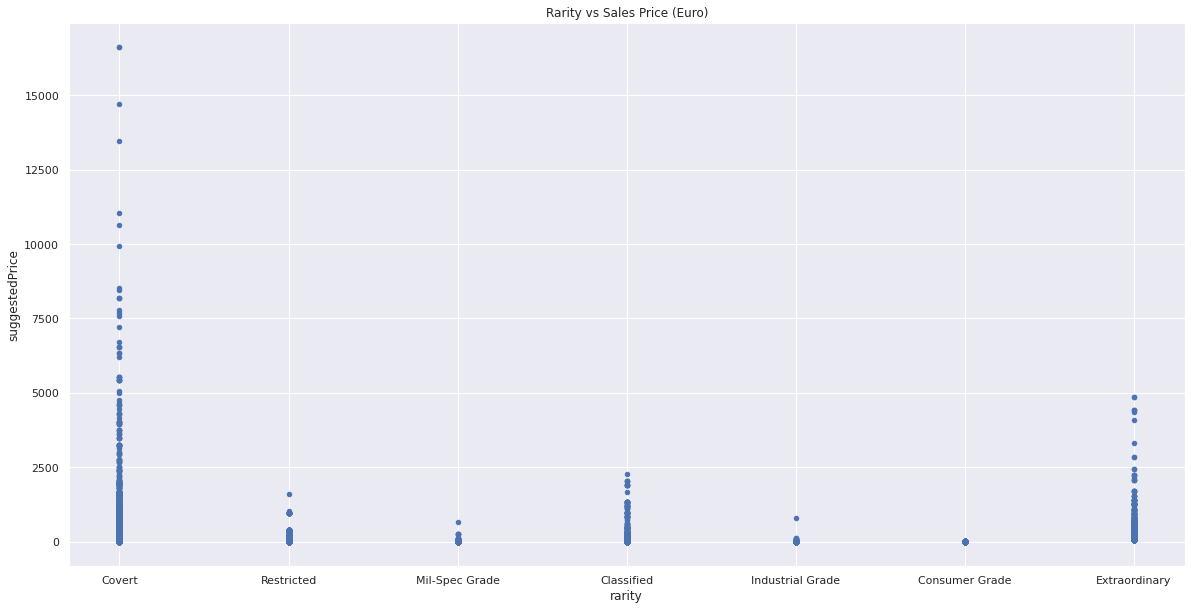

In [248]:
data.plot(kind='scatter', x='rarity', y='suggestedPrice', title='Rarity vs Sales Price (Euro)');

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


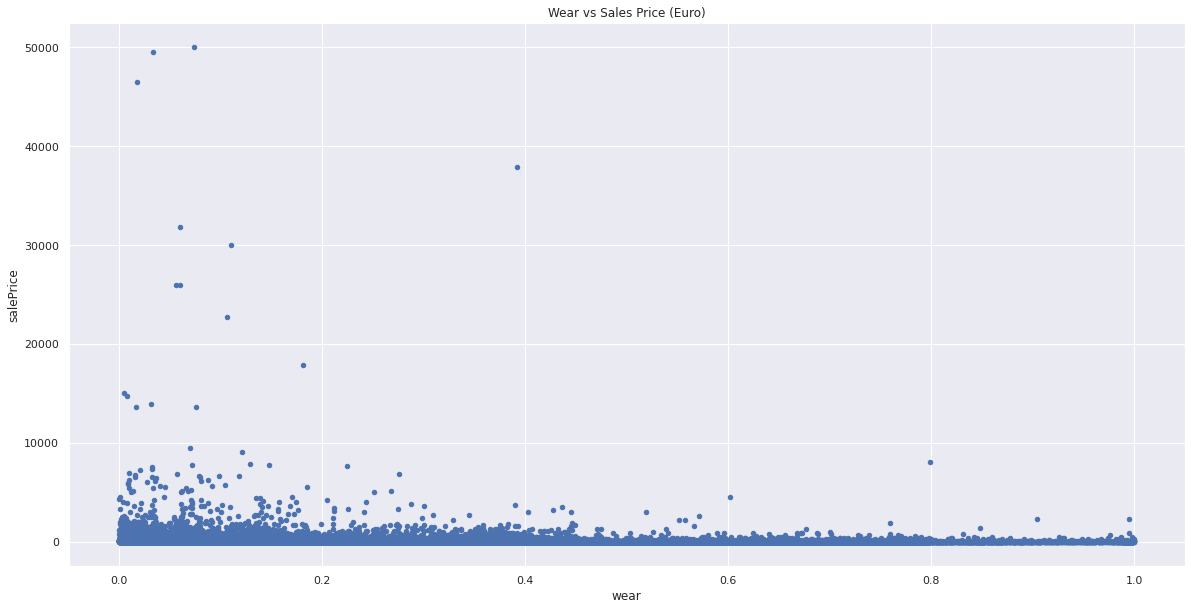

In [ ]:
data.plot(kind='scatter', x='wear', y='salePrice', title='Wear vs Sales Price (Euro)');

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


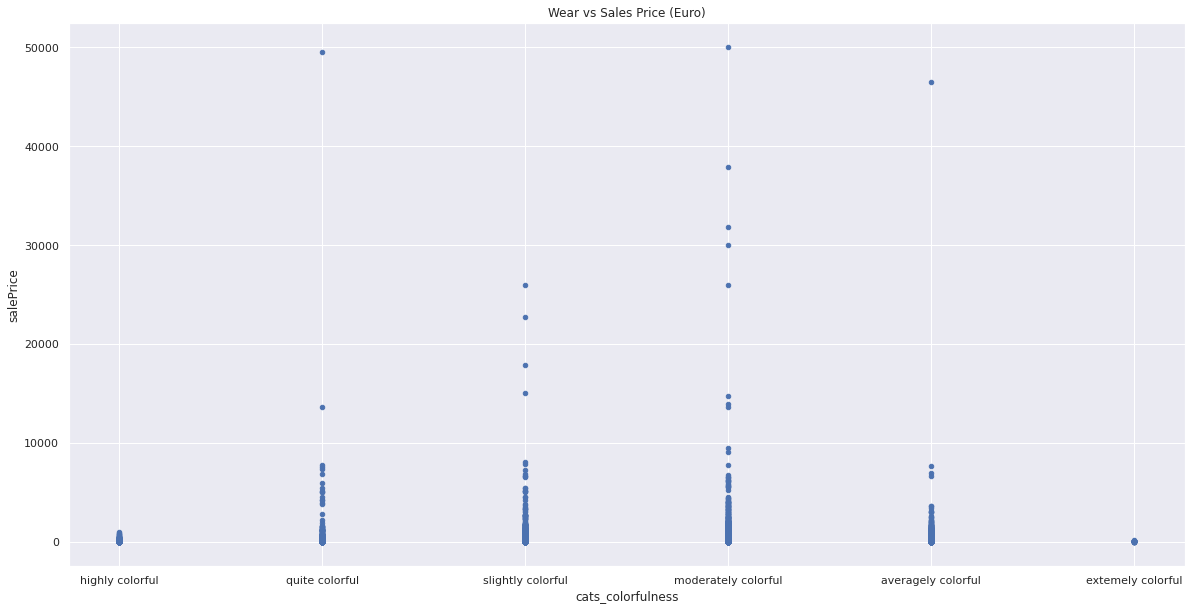

In [ ]:
data.plot(kind='scatter', x='cats_colorfulness', y='salePrice', title='Wear vs Sales Price (Euro)');

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


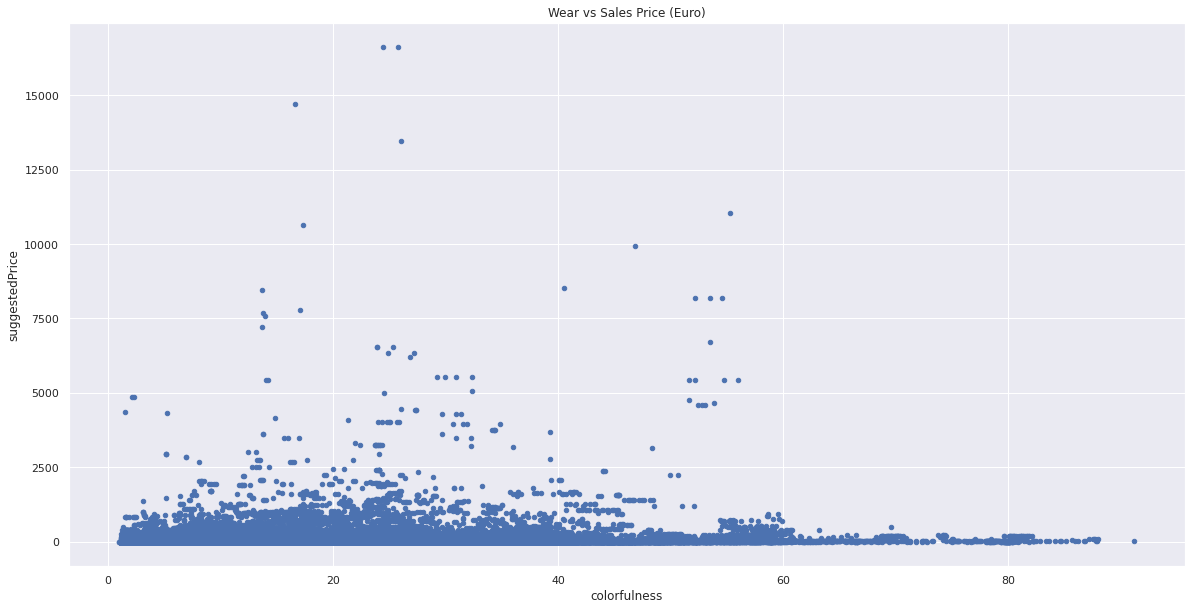

In [ ]:
data.plot(kind='scatter', x='colorfulness', y='salePrice', title='Wear vs Sales Price (Euro)');

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


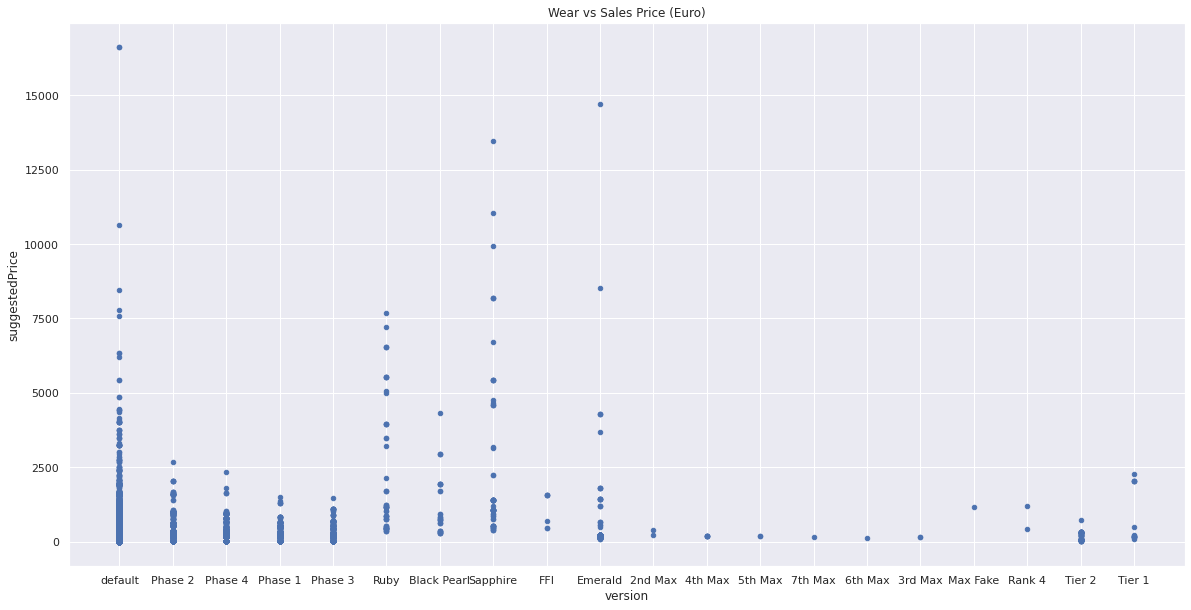

In [ ]:
plt.rcParams.update({'font.size': 20, 'figure.figsize': (20, 10)})

data.plot(kind='scatter', x='version', y='salePrice', title='Wear vs Sales Price (Euro)');

In [ ]:
data_ue20k = data[data['salePrice'] >= 20000]

In [ ]:
data_ue10k = data[data['salePrice'] >= 10000]

In [ ]:
data_ue10k

,index,assetId,family,color,lock,version,versionType,suggestedPrice,salePrice,category,...,exterior,quality,rarity,rarityColor,collection,stickers,souvenir,stattrak,colorfulness,cats_colorfulness
800,822,41787087,Doppler,#8650AC,0,Sapphire,phase,13461.54,13906.90,Knife,...,Factory New,★,Covert,#eb4b4b,The Breakout Collection,0,0,0,26.052475,moderately colorful
846,868,57386498,Gamma Doppler,#8650AC,0,Emerald,phase,14697.21,14700.87,Knife,...,Factory New,★,Covert,#eb4b4b,The Breakout Collection,0,0,0,16.608317,moderately colorful
2932,2998,47663996,Doppler,#8650AC,1,Sapphire,phase,9940.10,13627.13,Knife,...,Factory New,★,Covert,#eb4b4b,No Collection,0,0,0,46.872878,quite colorful
7253,7421,42288854,Cobalt Disruption,#D2D2D2,0,default,default,61.49,46505.17,Pistol,...,Factory New,Normal,Classified,#d32ee6,The eSports 2013 Winter Collection,1,0,0,43.392093,averagely colorful
25724,25895,45506601,Valence,#D2D2D2,0,default,default,0.60,49560.28,Pistol,...,Factory New,Normal,Mil-Spec Grade,#4b69ff,The Chroma 2 Collection,1,0,0,48.083679,quite colorful
27121,27292,43907576,Sand Dune,#FFD700,0,default,default,0.39,37880.51,Pistol,...,Well-Worn,Souvenir,Consumer Grade,#b0c3d9,The Dust 2 Collection,1,1,0,28.512152,moderately colorful
42223,42395,36210877,Redline,#CF6A32,0,default,default,154.38,22711.88,Rifle,...,Minimal Wear,StatTrak™,Classified,#d32ee6,The Phoenix Collection,1,0,1,10.358685,slightly colorful
43479,43651,49905872,Case Hardened,#CF6A32,0,Tier 2,pattern,265.04,30000.00,Rifle,...,Minimal Wear,StatTrak™,Classified,#d32ee6,The Arms Deal Collection,1,0,1,20.445109,moderately colorful
61329,61501,33573999,Howl,#CF6A32,0,default,default,16609.35,26000.00,Rifle,...,Factory New,StatTrak™,Covert,#eb4b4b,No Collection,1,0,1,24.433518,moderately colorful
61332,61504,26587537,Howl,#CF6A32,0,default,default,16609.35,31795.72,Rifle,...,Factory New,StatTrak™,Covert,#eb4b4b,No Collection,1,0,1,25.731520,moderately colorful


In [ ]:
20000

In [ ]:
sns.set(rc={'figure.figsize':(12,8.5)})

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


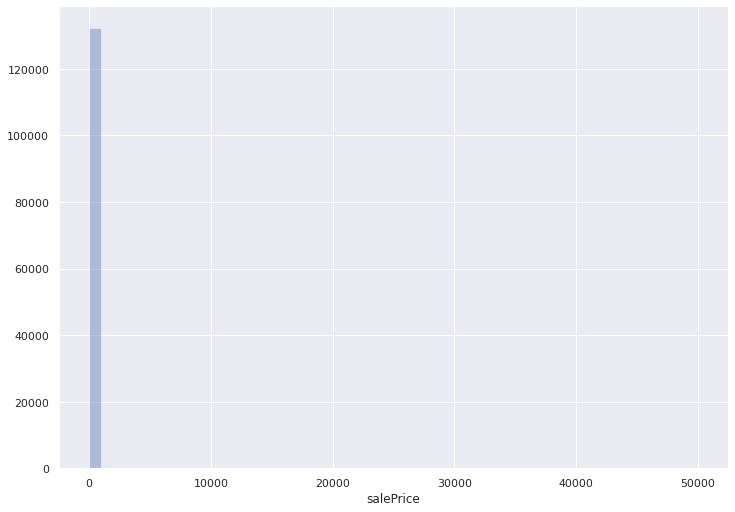

In [ ]:
sns.distplot(data['salePrice'], kde = False)

#TEST Erste Visualisierungen

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


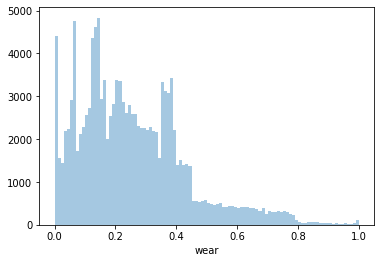

In [ ]:
#distribution plot
#distribution for 1 var

sns.distplot(data['wear'], kde = False)# , bins=100)
#balken sind histogram
#linie ist "kernal density estimation" false

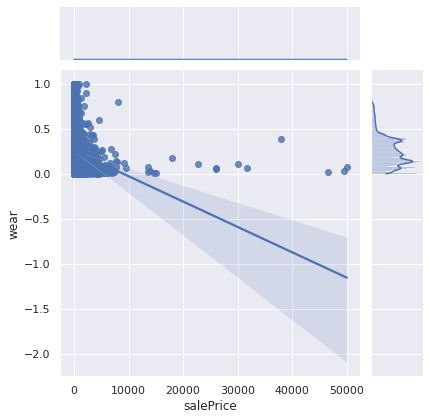

In [ ]:
#Joint Plot
#compare 2 distribution

sns.jointplot(x='salePrice', y= 'wear', data = data, kind = 'reg')
# kind = kde: estimates the distribution of data
# kind = hex


#dauert 17 Minuten

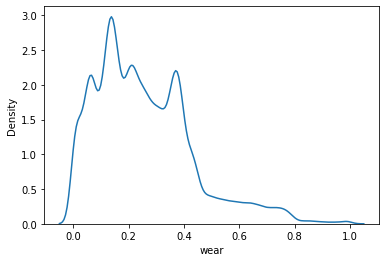

In [ ]:
#kde plot
sns.kdeplot(data['wear'])

In [ ]:
#pair plots
# hier sieht man, wie numerische vars sich verhalten gegenseitig
sns.pairplot(data)

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f73dbdaa050> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f73daca4e60> (for post_execute):


KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


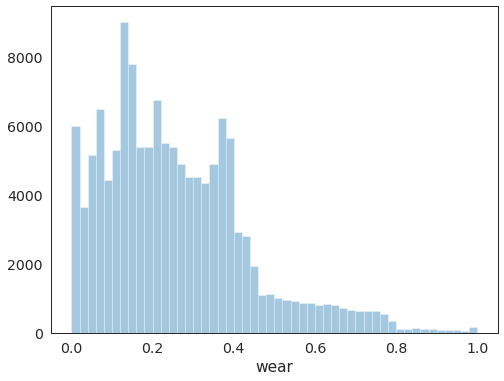

In [ ]:
sns.set_style('white')
plt.figure(figsize=(8,6))

sns.set_context('paper', font_scale=1.6)

sns.distplot(data['wear'], kde = False)

#sns.despine(left=False, bottom = False)

In [ ]:
##kategorialssss

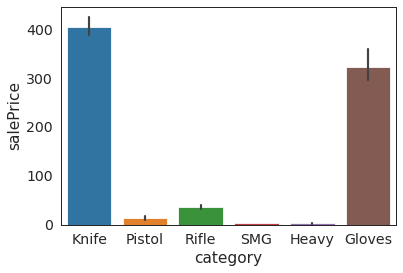

In [ ]:
#barplot
sns.barplot(x='category', y='salePrice', data=data)

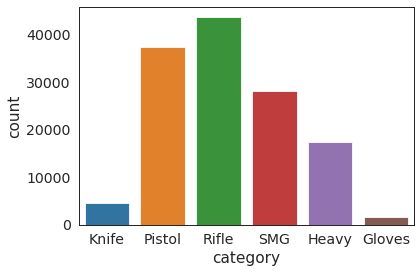

In [ ]:
#countplot
sns.countplot(x='category', data=data) #selten?

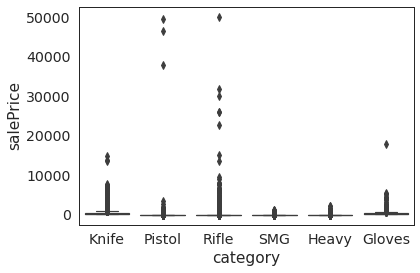

In [ ]:
#boxplot. herausfinden warum komisch 

sns.boxplot(x='category', y='salePrice', data=data)

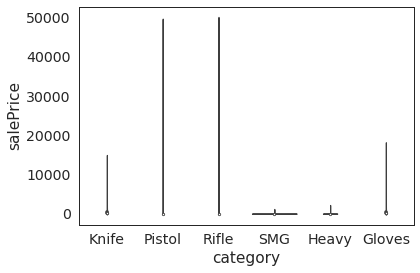

In [ ]:
sns.violinplot(x='category', y='salePrice', data=data)

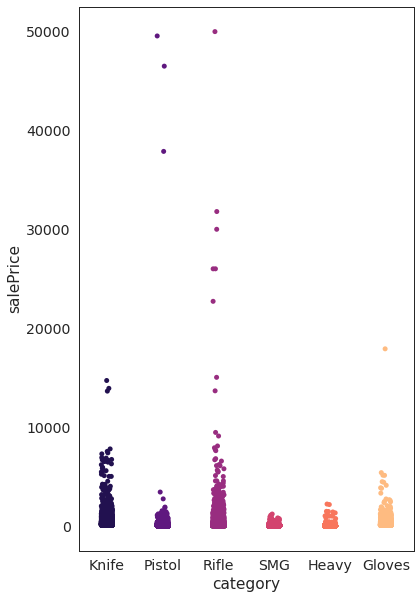

In [ ]:
plt.figure(figsize=(6,10))

sns.stripplot(x='category', y='salePrice', data=data, jitter=True, palette = 'magma')

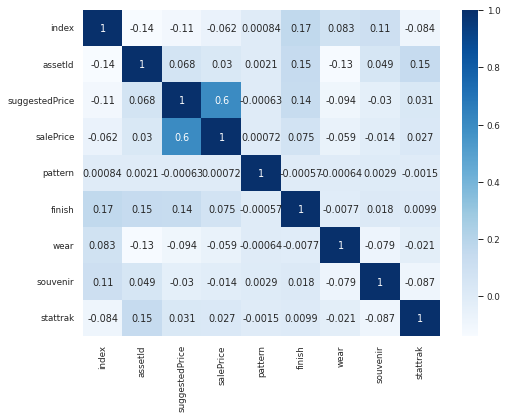

In [ ]:
#heatmaps
plt.figure(figsize=(8,6))
sns.set_context('paper')

data_mx = data.corr()

sns.heatmap(data_mx, annot=True, cmap='Blues')

In [ ]:
preise = data.pivot_table(index='category', columns='wear', values = 'salePrice')
preise

###Balanced Data?

In [ ]:
data.category.value_counts()
# 1 :  2,9  :    10,8  : 17,4 :  23,1  : 27,1
#-> 1:27,1

Rifle     43665
Pistol    37346
SMG       28128
Heavy     17465
Knife      4604
Gloves     1614
Name: category, dtype: int64

Nova                 5979
PP-Bizon             5753
AUG                  5604
AK-47                5376
P250                 5340
                     ... 
Paracord Knife        105
Skeleton Knife        105
Survival Knife         85
Bloodhound Gloves      77
Nomad Knife            53
Name: subCategory, Length: 61, dtype: int64

###Strategie Datenaufbereitung für Modelle:


- assetId: passt
- family: eig zu viel
- color: Datentyp ändern, auf int64 umstellen, 4 Ausprägungen
- lock: passt
- version: genauer angucken, villeicht one hot encoding?
- versionType: kann man eig rausschmeißen, ist überordnung von version
- suggestedPrice: passt
- salePrice: passt
- Category: One Hot Encoding
- subCategory: viele ausprägungen... ohe?
- pattern: passt
- finish: passt
- wear: passt
- type: gute allg. Beschreibung, vollständig.. ohe?
- exterior: lable encoding
- quality: lable encoding
- rarity: lable encoding
- collection: nochmal angucken, ohe?
- stickers: passt
- souvenir: passt
- stattrack: passt

wenn zu viel OHE, dann frequency-encoding probieren?
https://medium.com/swlh/stop-one-hot-encoding-your-categorical-features-avoid-curse-of-dimensionality-16743c32cea4
"The frequency distribution of the column Country can be generated using the pandas' function: data[‘country’].value_counts()
Now replace each of the categories with their frequency in the data, for example, United States will be replaced by 7768, Russia by 1161. This technique is very each to implement and is a tremendously popular technique amongst Kagglers.
The downside of using this technique, if some categories have the same count, then they will be treated similarly by the model, hence losing some information."

####Daten in richriges Format bringen

numpy.float64

In [ ]:
data.shape

(133005, 22)

In [ ]:
data.describe()

,index,assetId,suggestedPrice,salePrice,pattern,finish,wear,souvenir,stattrak
count,132822.000000,1.328220e+05,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000
mean,66580.896501,4.724622e+07,29.443286,34.422234,500.392533,647.262283,0.255292,0.063988,0.099991
std,38352.754248,1.329716e+07,202.335509,372.976511,288.729975,1106.288792,0.177134,0.244732,0.299989
min,0.000000,1.240700e+04,0.030000,0.020000,0.000000,2.000000,0.000007,0.000000,0.000000
25%,33377.250000,3.878514e+07,0.030000,0.030000,250.000000,136.000000,0.125445,0.000000,0.000000
50%,66583.500000,5.176906e+07,0.100000,0.120000,500.000000,611.000000,0.223606,0.000000,0.000000
75%,99792.750000,5.838940e+07,1.590000,3.000000,751.000000,841.000000,0.361484,0.000000,0.000000
max,133004.000000,6.096650e+07,16609.350000,49999.990000,1000.000000,10088.000000,0.999827,1.000000,1.000000


In [ ]:
data.category.describe()

count     132822
unique         6
top        Rifle
freq       43665
Name: category, dtype: object

In [ ]:
data.category.value_counts()

Rifle     43665
Pistol    37346
SMG       28128
Heavy     17465
Knife      4604
Gloves     1614
Name: category, dtype: int64

In [ ]:
data.corr()
'''Die Untersuchung bivariater Beziehungen ist nützlich, wenn Sie ein Ergebnis oder eine abhängige 
Variable im Auge haben und die Merkmale sehen möchten, die am stärksten mit der Zunahme oder Abnahme 
des Ergebnisses korrelieren. Sie können bivariate Beziehungen mit Hilfe von Streudiagrammen visuell 
darstellen (siehe unten im Abschnitt über die Darstellung).'''

,assetId,suggestedPrice,salePrice,pattern,finish,wear,souvenir,stattrak
assetId,1.000000,0.068925,0.030860,0.002147,0.148031,-0.133814,0.048783,0.145395
suggestedPrice,0.068925,1.000000,0.601326,-0.000339,0.139428,-0.092672,-0.030024,0.031478
salePrice,0.030860,0.601326,1.000000,0.000858,0.075266,-0.059053,-0.013972,0.027527
pattern,0.002147,-0.000339,0.000858,1.000000,-0.000575,-0.000563,0.002910,-0.001460
finish,0.148031,0.139428,0.075266,-0.000575,1.000000,-0.007651,0.017888,0.009874
wear,-0.133814,-0.092672,-0.059053,-0.000563,-0.007651,1.000000,-0.079354,-0.021019
souvenir,0.048783,-0.030024,-0.013972,0.002910,0.017888,-0.079354,1.000000,-0.087119
stattrak,0.145395,0.031478,0.027527,-0.001460,0.009874,-0.021019,-0.087119,1.000000


In [ ]:
data.groupby('category')['salePrice'].median()

category
Gloves    161.915
Heavy       0.040
Knife     235.000
Pistol      0.220
Rifle       0.350
SMG         0.040
Name: salePrice, dtype: float64

#Ausprobiertes

###Bilder

In [ ]:
url = "https://cdn.skinport.com/images/screenshots/55026078/playside_256x128.png"

In [ ]:

im = Image.open(requests.get(url, stream=True).raw)

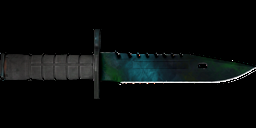

In [ ]:
rgb_image

###Sortierung

In [ ]:
data.groupby('version')['salePrice'].median().sort_values(ascending=False)

version
Max Fake       2089.490
FFI            1295.890
Sapphire       1125.200
Ruby            988.305
Rank 4          787.425
Black Pearl     707.825
2nd Max         613.225
Tier 1          274.995
Emerald         193.000
5th Max         164.750
4th Max         162.500
Phase 3         161.930
Phase 1         155.250
3rd Max         155.000
6th Max         145.000
Phase 4         143.380
7th Max         138.000
Phase 2         114.990
Tier 2           85.435
default           0.110
Name: salePrice, dtype: float64

In [ ]:
data.columns

Index(['index', 'assetId', 'family', 'color', 'lock', 'version', 'versionType',
       'suggestedPrice', 'salePrice', 'category', 'subCategory', 'pattern',
       'finish', 'wear', 'type', 'exterior', 'quality', 'rarity',
       'rarityColor', 'collection', 'stickers', 'souvenir', 'stattrak',
       'colorfulness'],
      dtype='object')

In [ ]:
data.groupby('category')['salePrice'].mean().sort_values(ascending=False)

category
Knife     405.147018
Gloves    321.788625
Rifle      35.712259
Pistol     13.483098
SMG         2.969100
Heavy       2.343877
Name: salePrice, dtype: float64

In [ ]:
data.groupby('color')['salePrice'].mean().sort_values(ascending=False)
# diese farbe ist am teuersten

color
#8650AC    383.509764
#CF6A32     41.549811
#FFD700     14.806967
#D2D2D2     14.577709
Name: salePrice, dtype: float64

In [ ]:
data.groupby('color')['salePrice'].count().sort_values(ascending=False)
# und am seltensten

color
#D2D2D2    105506
#CF6A32     12599
#FFD700      8499
#8650AC      6218
Name: salePrice, dtype: int64

In [ ]:
data.groupby('lock')['salePrice'].mean().sort_values(ascending=False)
# locked items sind teurer?

lock
1    56.873882
0    28.074106
Name: salePrice, dtype: float64

In [ ]:
data.groupby('subCategory')['salePrice'].mean().sort_values(ascending=False)

subCategory
Butterfly Knife    1096.501444
Karambit            828.503555
Sport Gloves        791.677727
M9 Bayonet          621.245828
Talon Knife         595.457357
                      ...     
Sawed-Off             0.837919
Nova                  0.822243
R8 Revolver           0.801825
PP-Bizon              0.573822
G3SG1                 0.474684
Name: salePrice, Length: 61, dtype: float64

In [ ]:
data.groupby('pattern')['salePrice'].mean().sort_values(ascending=False)

pattern
848    447.954444
655    442.093714
76     415.011774
598    369.194593
320    338.482479
          ...    
342      7.662985
438      7.625492
334      7.149063
604      7.120833
780      5.992667
Name: salePrice, Length: 1001, dtype: float64

In [ ]:
data.groupby('finish')['salePrice'].mean().sort_values(ascending=False)

finish
309    8797.286500
756    8245.200000
724    5397.286667
344    5069.183750
619    3121.148000
          ...     
148       0.048695
107       0.045000
242       0.034181
753       0.033190
245       0.025324
Name: salePrice, Length: 1082, dtype: float64

In [ ]:
data.groupby('wear')['salePrice'].mean().sort_values(ascending=False)

wear
0.073958    49999.99
0.033475    49560.28
0.017549    46505.17
0.391709    37880.51
0.110181    30000.00
              ...   
0.168360        0.02
0.215616        0.02
0.168362        0.02
0.340327        0.02
0.240867        0.02
Name: salePrice, Length: 132514, dtype: float64

In [ ]:
data.groupby('exterior')['salePrice'].mean().sort_values(ascending=False)

exterior
Factory New       110.359053
Minimal Wear       41.337280
Field-Tested       15.985946
Well-Worn          15.813042
Battle-Scarred     13.567481
Name: salePrice, dtype: float64

In [ ]:
data.groupby('quality')['salePrice'].mean().sort_values(ascending=False)

quality
★ StatTrak™    492.520220
★              370.080368
StatTrak™       41.549811
Souvenir        14.806967
Normal          14.577709
Name: salePrice, dtype: float64

In [ ]:
data.groupby('rarity')['salePrice'].mean().sort_values(ascending=False)

rarity
Extraordinary       321.788625
Covert              236.128163
Classified           70.973676
Restricted           18.799357
Mil-Spec Grade        4.204628
Industrial Grade      3.847828
Consumer Grade        0.931931
Name: salePrice, dtype: float64

In [ ]:
data.groupby('collection')['salePrice'].mean().sort_values(ascending=False)

collection
The Assault Collection        653.222895
The Arms Deal Collection      463.896024
No Collection                 425.054862
The Bravo Collection          346.157920
The Cobblestone Collection    308.122428
                                 ...    
The 2018 Nuke Collection        0.506119
The Italy Collection            0.445951
The Blacksite Collection        0.387745
The Train Collection            0.383269
The Bank Collection             0.370072
Name: salePrice, Length: 75, dtype: float64

In [ ]:
data.groupby('stickers')['salePrice'].mean().sort_values(ascending=False)

stickers
1    56.167214
0    29.677878
Name: salePrice, dtype: float64

In [ ]:
data.groupby('souvenir')['salePrice'].mean().sort_values(ascending=False)

souvenir
0    35.763178
1    14.806967
Name: salePrice, dtype: float64

In [ ]:
data.groupby('colorfulness')['salePrice'].mean().sort_values(ascending=False)

colorfulness
25.851920    49999.99
48.083679    49560.28
43.392093    46505.17
28.512152    37880.51
25.731520    31795.72
               ...   
12.868505        0.02
12.870043        0.02
12.870278        0.02
12.871776        0.02
11.842466        0.02
Name: salePrice, Length: 132820, dtype: float64

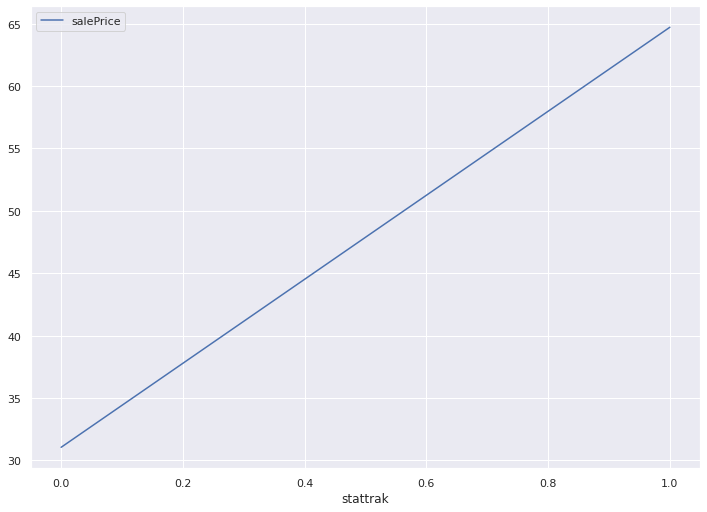

In [ ]:
data.groupby('stattrak')['salePrice'].mean().sort_values(ascending=False).plot(legend=True)

In [ ]:
data.groupby('cats_colorfulness')['salePrice'].median().sort_values(ascending=False)#.plot(legend=True)

cats_colorfulness
extemely colorful      13.47
quite colorful          9.49
highly colorful         9.03
averagely colorful      5.93
moderately colorful     1.20
slightly colorful       0.04
Name: salePrice, dtype: float64